## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import urllib.request
import bootcampviztools as bt
import toolbox_ML as tml

## Datos

In [86]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv", index_col=0)
df.index.name = None

## Exploración de los datos

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [88]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [89]:
df.describe()

,Inches,Price_in_euros
count,912.000000,912.000000
mean,14.981579,1111.724090
std,1.436719,687.959172
min,10.100000,174.000000
25%,14.000000,589.000000
50%,15.600000,978.000000
75%,15.600000,1483.942500
max,18.400000,6099.000000


## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [90]:
#df[df.duplicated()].sort_values("Product")

In [91]:
#df = df.drop_duplicates()

In [92]:
#df[df.duplicated()].sort_values("Product")

In [93]:
df['apple'] = df['Company'].str.contains(r'Apple', case=False, na=False).astype(int)


In [94]:
df.drop(columns=["Company", "Product"], inplace=True)

In [95]:
df['i3'] = df['Cpu'].str.contains(r'i3', case=False, na=False).astype(int)
df['i5'] = df['Cpu'].str.contains(r'i5', case=False, na=False).astype(int)
df['i7'] = df['Cpu'].str.contains(r'i7', case=False, na=False).astype(int)

In [96]:
df["inches"] = df.Inches.astype(float)
df['ram_gb'] = df['Ram'].str.replace('GB', '').astype(int)
df["weight_kg"] = df['Weight'].str.replace('kg', '').astype(float)

In [97]:
df.head()

,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,apple,i3,i5,i7,inches,ram_gb,weight_kg
755,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00,0,1,0,0,15.6,8,1.86
618,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01,0,0,0,1,15.6,16,2.59
909,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00,0,0,0,1,15.6,8,2.04
2,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1,0,1,0,13.3,8,1.34
286,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00,0,1,0,0,15.6,4,2.25


In [98]:
df["Touchscreen"] = df["ScreenResolution"].str.contains("Touchscreen").astype(int)

In [99]:
df["IPS"] = df["ScreenResolution"].str.contains("IPS").astype(int)

In [100]:
df["4K"] = df["ScreenResolution"].str.contains("4K").astype(int)

In [101]:
find_GB_TB = df["Memory"].str.findall(r"(\d+)(GB|TB)")

def convert_to_gb(list_of_tuples):
    total_gb = 0
    if list_of_tuples: 
        for (num, unit) in list_of_tuples:
            num = float(num)
            if unit == "TB":
                total_gb += num * 1024
            else: 
                total_gb += num
    return total_gb

df["total_memory_gb"] = find_GB_TB.apply(convert_to_gb)

In [102]:
df = pd.get_dummies(df, columns=["TypeName"], prefix="type")

In [103]:
df["type_2in1_convertible"] = df["type_2 in 1 Convertible"]
df.drop("type_2 in 1 Convertible", axis=1, inplace=True)

In [104]:
df[["width", "height"]] = df["ScreenResolution"].str.extract(r"(\d+)x(\d+)").astype(int)
df["total_pixels"] = df["width"] * df["height"]
df.head(3)

,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,apple,...,total_memory_gb,type_Gaming,type_Netbook,type_Notebook,type_Ultrabook,type_Workstation,type_2in1_convertible,width,height,total_pixels
755,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00,0,...,256.0,False,False,True,False,False,False,1920,1080,2073600
618,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01,0,...,1024.0,True,False,False,False,False,False,1920,1080,2073600
909,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00,0,...,1024.0,False,False,True,False,False,False,1920,1080,2073600


In [105]:
df['GPU_Nvidia'] = df['Gpu'].str.contains('Nvidia').astype(int)
df['GPU_Intel'] = df['Gpu'].str.contains('Intel').astype(int)
df['GPU_AMD'] = df['Gpu'].str.contains('AMD').astype(int)

print(df['GPU_AMD'].sum()+df['GPU_Intel'].sum()+df['GPU_Nvidia'].sum())

912


In [106]:
df["Frecuencia_GHz"] = df["Cpu"].str.extract(r"(\d+(?:\.\d+)?)GHz")
df.Frecuencia_GHz = df["Frecuencia_GHz"].astype(float)

In [107]:
df.drop(columns=["Cpu","Memory", "Ram", "Inches", "Weight", "ScreenResolution"], inplace=True)
df.head(3)

,Gpu,OpSys,Price_in_euros,apple,i3,i5,i7,inches,ram_gb,weight_kg,...,type_Ultrabook,type_Workstation,type_2in1_convertible,width,height,total_pixels,GPU_Nvidia,GPU_Intel,GPU_AMD,Frecuencia_GHz
755,Intel HD Graphics 520,Windows 10,539.00,0,1,0,0,15.6,8,1.86,...,False,False,False,1920,1080,2073600,0,1,0,2.0
618,Nvidia GeForce GTX 960<U+039C>,Windows 10,879.01,0,0,0,1,15.6,16,2.59,...,False,False,False,1920,1080,2073600,1,0,0,2.6
909,Nvidia GeForce 930MX,Windows 10,900.00,0,0,0,1,15.6,8,2.04,...,False,False,False,1920,1080,2073600,1,0,0,2.7


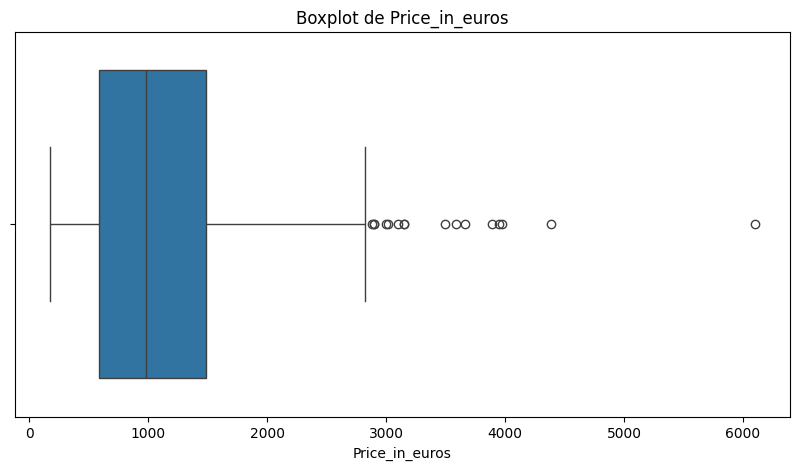

In [108]:
# Outliers de target
plt.figure(figsize=(10,5))
sns.boxplot(x=df["Price_in_euros"])
plt.title("Boxplot de Price_in_euros")
plt.show()

In [109]:
# Eliminar Outliers del target
df = df[df["Price_in_euros"] < 5000]
df.Price_in_euros.isnull().sum()

0

In [110]:
#df[df.Price_in_euros > 4000]

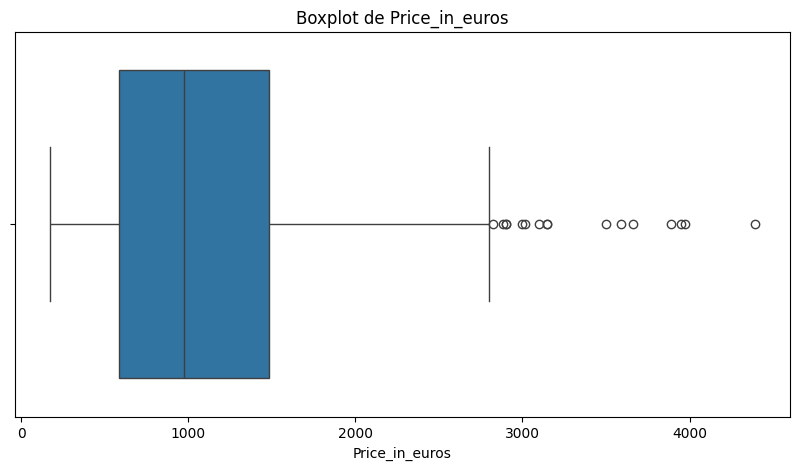

In [111]:
# Outliers de target
plt.figure(figsize=(10,5))
sns.boxplot(x=df["Price_in_euros"])
plt.title("Boxplot de Price_in_euros")
plt.show()

In [112]:
#df.Price_in_euros.fillna(df.Price_in_euros.mean(), inplace=True)

In [113]:
df.Price_in_euros = df.Price_in_euros.astype(float).round(2)
df.Price_in_euros.sample(1)

75    1095.0
Name: Price_in_euros, dtype: float64

In [114]:
df.drop(columns=["width", "height"], inplace=True)

In [115]:
df['GPU_GeForceGTX'] = df['Gpu'].str.contains('GeForce GTX').astype(int)


In [116]:
df["GPU_GeForceGTX"].isnull().sum()

0

In [117]:
df.drop(columns=["Gpu"], inplace=True)

In [118]:
df.drop(columns=["OpSys"], inplace=True)

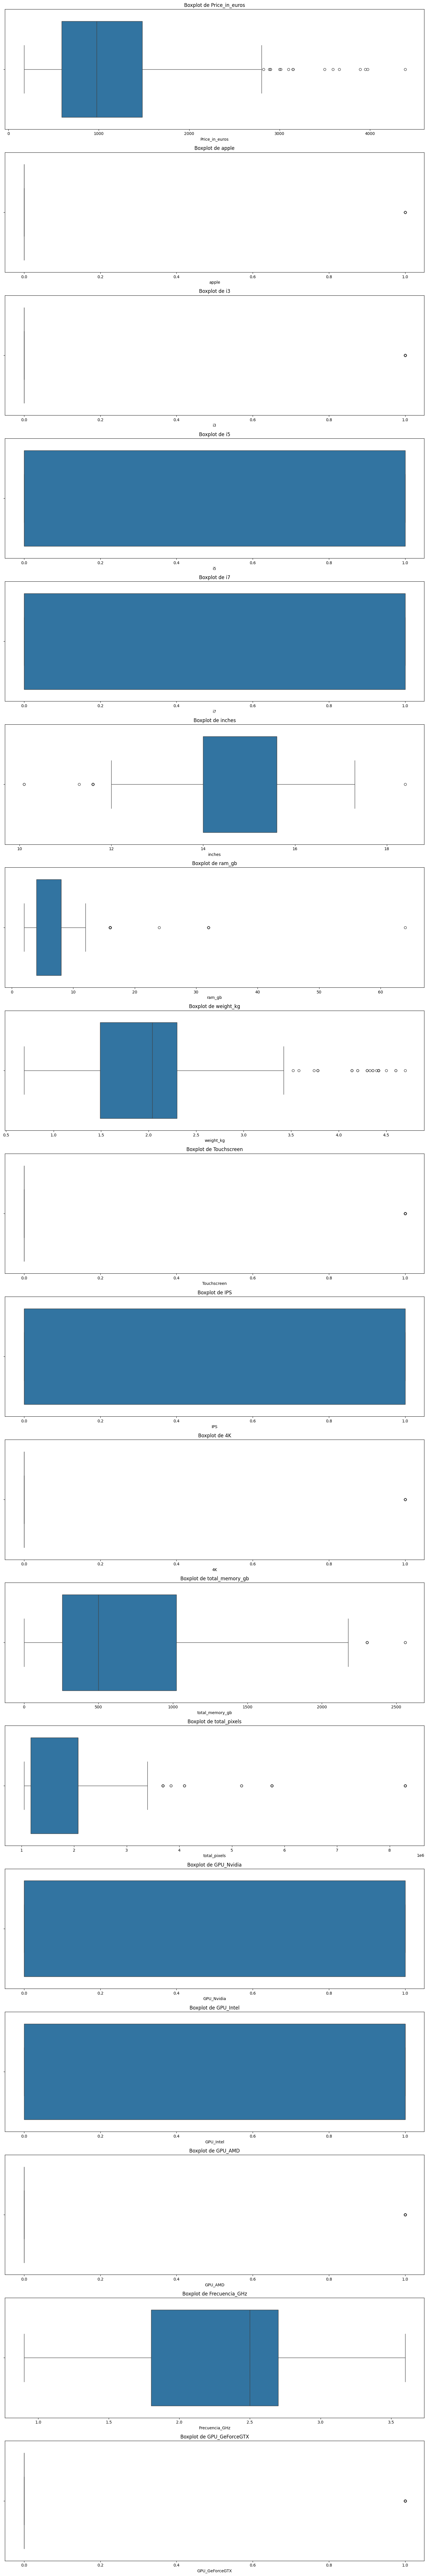

In [119]:
# Boxplot de todas las features
numeric_columns = df.select_dtypes(include=['number']).columns

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5 * len(numeric_columns)))

# Crear un boxplot para cada columna numérica
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


In [120]:
matriz_corr = df.corr(numeric_only=True)

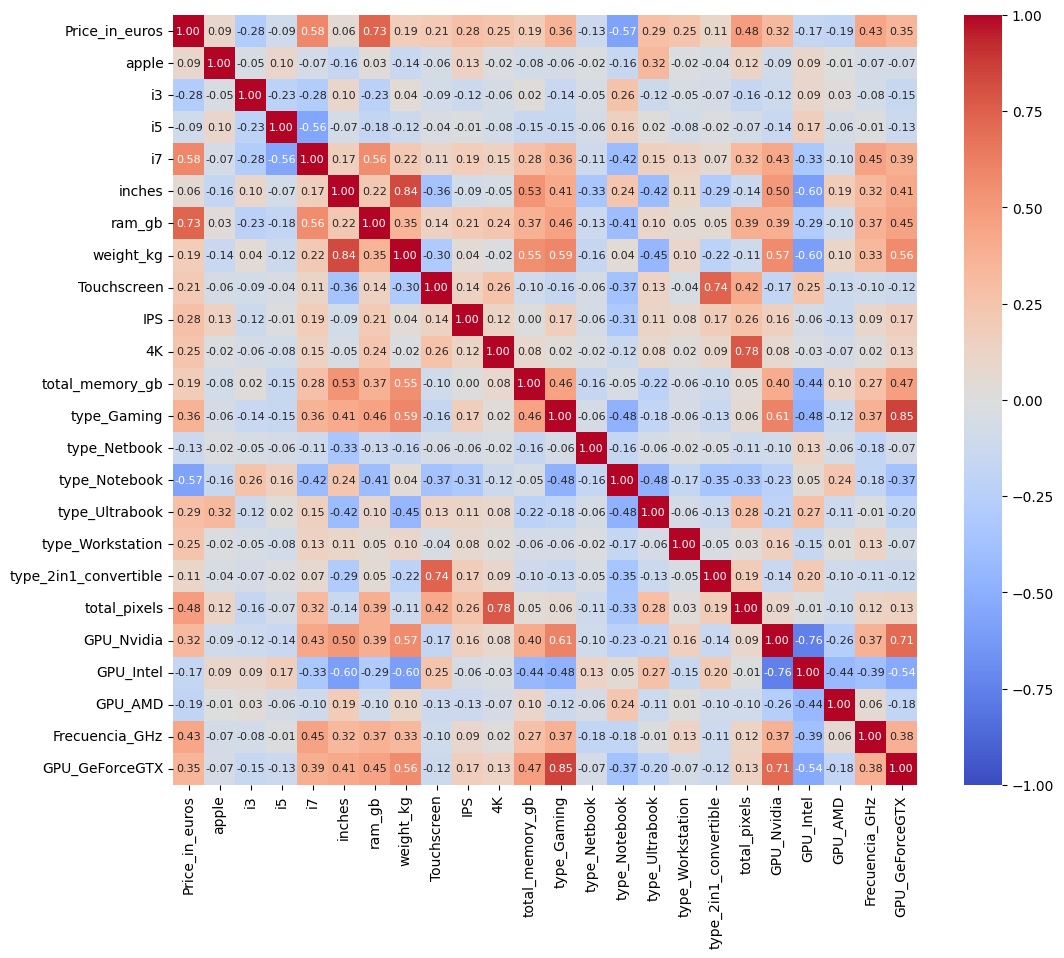

In [121]:
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=True, annot_kws={"size": 8}, fmt=".2f")
plt.show()

In [122]:
tml.describe_df(df)

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
Price_in_euros,float64,0,602,66.08
apple,int32,0,2,0.22
i3,int32,0,2,0.22
i5,int32,0,2,0.22
i7,int32,0,2,0.22
inches,float64,0,17,1.87
ram_gb,int32,0,9,0.99
weight_kg,float64,0,157,17.23
Touchscreen,int32,0,2,0.22
IPS,int32,0,2,0.22


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 911 entries, 755 to 229
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price_in_euros         911 non-null    float64
 1   apple                  911 non-null    int32  
 2   i3                     911 non-null    int32  
 3   i5                     911 non-null    int32  
 4   i7                     911 non-null    int32  
 5   inches                 911 non-null    float64
 6   ram_gb                 911 non-null    int32  
 7   weight_kg              911 non-null    float64
 8   Touchscreen            911 non-null    int32  
 9   IPS                    911 non-null    int32  
 10  4K                     911 non-null    int32  
 11  total_memory_gb        911 non-null    float64
 12  type_Gaming            911 non-null    bool   
 13  type_Netbook           911 non-null    bool   
 14  type_Notebook          911 non-null    bool   
 15  type_Ultr

In [124]:
# Vamos a sacar las features importantes

X = df.drop(columns="Price_in_euros")
y = df["Price_in_euros"]

modelaje = RandomForestRegressor(random_state=42)
modelaje.fit(X, y)

importantes_features = modelaje.feature_importances_
feature_names = X.columns

feat_importancia = sorted(zip(feature_names, importantes_features), key=lambda x: x[1], reverse=True)
for feature, importance in feat_importancia:
    print(f"{feature}: {importance:.4f}")

ram_gb: 0.5117
weight_kg: 0.1258
type_Notebook: 0.0657
i7: 0.0597
Frecuencia_GHz: 0.0578
inches: 0.0348
total_memory_gb: 0.0298
total_pixels: 0.0274
i5: 0.0243
type_Workstation: 0.0214
IPS: 0.0102
type_Gaming: 0.0045
GPU_GeForceGTX: 0.0042
Touchscreen: 0.0037
GPU_Nvidia: 0.0033
type_Ultrabook: 0.0032
type_2in1_convertible: 0.0026
GPU_AMD: 0.0024
i3: 0.0024
GPU_Intel: 0.0023
4K: 0.0021
apple: 0.0003
type_Netbook: 0.0003


In [125]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")
selector.fit(X, y)

selected_features = X.columns[selector.get_support()]
print("Features seleccionadas:", selected_features)


Features seleccionadas: Index(['i5', 'i7', 'inches', 'ram_gb', 'weight_kg', 'IPS', 'total_memory_gb',
       'type_Gaming', 'type_Notebook', 'type_Workstation', 'total_pixels',
       'Frecuencia_GHz'],
      dtype='object')


-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [126]:
X = df.drop(['Price_in_euros'], axis=1)
y = df['Price_in_euros'].copy()
X.shape

(911, 23)

In [127]:
X.columns

Index(['apple', 'i3', 'i5', 'i7', 'inches', 'ram_gb', 'weight_kg',
       'Touchscreen', 'IPS', '4K', 'total_memory_gb', 'type_Gaming',
       'type_Netbook', 'type_Notebook', 'type_Ultrabook', 'type_Workstation',
       'type_2in1_convertible', 'total_pixels', 'GPU_Nvidia', 'GPU_Intel',
       'GPU_AMD', 'Frecuencia_GHz', 'GPU_GeForceGTX'],
      dtype='object')

In [128]:
#X = df.iloc[:, [7,9,10,12,14,20]].copy()
#y = df.iloc[:, 4].copy()

In [129]:
X = df[["ram_gb", "total_memory_gb", "i7", "GPU_GeForceGTX"]].copy()
y = df["Price_in_euros"].copy()

In [130]:
#X = df[["ram_gb","weight_kg","type_Notebook", "Frecuencia_GHz","i7", "inches", "total_memory_gb", "total_pixels"]].copy()
#y = df["Price_in_euros"].copy()

In [131]:
X.shape

(911, 4)

In [132]:
y.shape

(911,)

### 2. Dividir X_train, X_test, y_train, y_test

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [134]:
X_train = X_train.astype({"type_Notebook": int, "type_Workstation": int})


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'type_Notebook' not found in columns."

In [135]:
X_train

,ram_gb,total_memory_gb,i7,GPU_GeForceGTX
1118,8,1024.0,1,0
563,4,32.0,0,0
275,8,512.0,0,0
1211,8,256.0,0,0
131,16,2304.0,1,0
...,...,...,...,...
95,8,256.0,0,1
647,16,1024.0,1,1
187,8,128.0,0,0
775,4,1024.0,0,0


In [136]:
y_train

1118    2899.00
563      255.00
275     1958.90
1211    1163.00
131     1396.00
         ...   
95      1195.00
647     2399.00
187      793.00
775      470.34
762     1096.00
Name: Price_in_euros, Length: 728, dtype: float64

### 3. Baseline de modelos


In [137]:
xgb_model = XGBRegressor(n_estimators=200, max_depth = 6, leaning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = root_mean_squared_error(y_test,y_pred_xgb)
print(F"RMSE con XGBoost (sin escalar): {rmse_xgb:.4f}")

RMSE con XGBoost (sin escalar): 334.6516


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "leaning_rate" } are not used.

  warnings.warn(smsg, UserWarning)


In [138]:
RFmodel = RandomForestRegressor()
RFmodel.fit(X_train, y_train)

RandomForestRegressor()

In [139]:
X_test = X_test.astype({"type_Notebook": int, "type_Workstation": int})


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'type_Notebook' not found in columns."

In [140]:
y_pred = RFmodel.predict(X_test)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [141]:
RMSE = root_mean_squared_error(y_test, y_pred)
RMSE

317.21489760541573

In [142]:
# Para buscar mejores parametros
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': np.arange(2, 15, 2),
    'min_samples_leaf': np.arange(1, 10, 2),
    'max_features': ['auto', 'sqrt']
}

random_search = RandomizedSearchCV(
    estimator=RFmodel,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train,y_train)

print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Mejor RMSE: {random_search.best_score_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 50}
Mejor RMSE: -420.12111658171307


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklear

In [143]:
best_params = random_search.best_params_
print(best_params)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 50}


In [144]:
# Con hiperparámetros optimizados
final_model = RandomForestRegressor(**best_params, random_state=42)

final_model.fit(X_train, y_train)

y_pred_optimizado = final_model.predict(X_test)


In [145]:
rmse_baseline = root_mean_squared_error(y_test, y_pred)
rmse_optimized = root_mean_squared_error(y_test, y_pred_optimizado)

print(f"RMSE Baseline: {rmse_baseline:.2f}")
print(f"RMSE Optimizado: {rmse_optimized:.2f}")

RMSE Baseline: 317.21
RMSE Optimizado: 316.85


In [146]:
# Comparar el RMSE en entrenamiento y validación
y_train_pred = final_model.predict(X_train)

rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_pred_optimizado)

print(f"RMSE en Entrenamiento: {rmse_train:.4f}")
print(f"RMSE en Test: {rmse_test:.4f}")


RMSE en Entrenamiento: 389.8176
RMSE en Test: 316.8469


In [147]:
# Vamos a tocar los best_params para ver si podemos mejorar el modelo
#best_params["max_depth"] = None
#best_params["min_samples_leaf"] = 1
#best_params["min_samples_split"] = 6

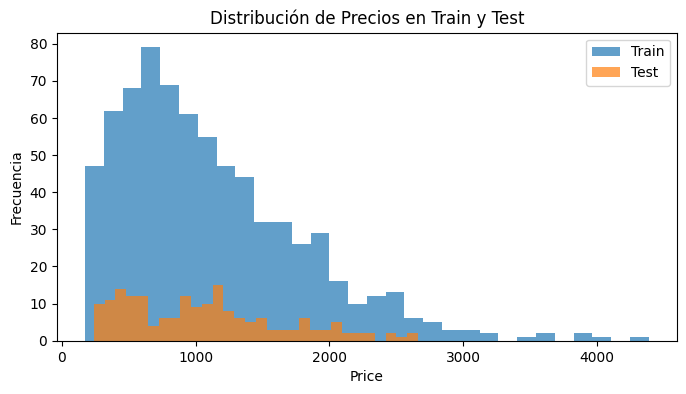

In [148]:
plt.figure(figsize=(8,4))
plt.hist(y_train, bins=30, alpha=0.7, label="Train")
plt.hist(y_test, bins=30, alpha=0.7, label="Test")
plt.legend()
plt.xlabel("Price")
plt.ylabel("Frecuencia")
plt.title("Distribución de Precios en Train y Test")
plt.show()


In [149]:
#df.Price_in_euros.value_counts().sort_index(ascending=False)

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [150]:
X_pred = pd.read_csv("./data/test.csv", index_col=0)
X_pred.index.name = None
X_pred

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg
...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg


In [151]:
X_pred['apple'] = X_pred['Company'].str.contains(r'Apple', case=False, na=False).astype(int)


In [152]:
X_pred.drop(columns=["Company", "Product"], inplace=True)

In [153]:
X_pred['i3'] = X_pred['Cpu'].str.contains(r'i3', case=False, na=False).astype(int)
X_pred['i5'] = X_pred['Cpu'].str.contains(r'i5', case=False, na=False).astype(int)
X_pred['i7'] = X_pred['Cpu'].str.contains(r'i7', case=False, na=False).astype(int)

In [154]:
X_pred["inches"] = X_pred.Inches.astype(float)
X_pred['ram_gb'] = X_pred['Ram'].str.replace('GB', '').astype(int)
X_pred["weight_kg"] = X_pred['Weight'].str.replace('kg', '').astype(float)

In [155]:
X_pred["Touchscreen"] = X_pred["ScreenResolution"].str.contains("Touchscreen").astype(int)

In [156]:
X_pred["IPS"] = X_pred["ScreenResolution"].str.contains("IPS").astype(int)

In [157]:
X_pred["4K"] = X_pred["ScreenResolution"].str.contains("4K").astype(int)

In [158]:
find_GB_TB = X_pred["Memory"].str.findall(r"(\d+)(GB|TB)")

def convert_to_gb(list_of_tuples):
    total_gb = 0
    if list_of_tuples: 
        for (num, unit) in list_of_tuples:
            num = float(num)
            if unit == "TB":
                total_gb += num * 1024
            else: 
                total_gb += num
    return total_gb

X_pred["total_memory_gb"] = find_GB_TB.apply(convert_to_gb)

In [159]:
X_pred = pd.get_dummies(X_pred, columns=["TypeName"], prefix="type")
X_pred["type_2in1_convertible"] = X_pred["type_2 in 1 Convertible"]
X_pred.drop("type_2 in 1 Convertible", axis=1, inplace=True)
X_pred

,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,apple,i3,...,Touchscreen,IPS,4K,total_memory_gb,type_Gaming,type_Netbook,type_Notebook,type_Ultrabook,type_Workstation,type_2in1_convertible
209,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg,0,0,...,0,0,0,512.0,True,False,False,False,False,False
1281,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg,0,0,...,0,0,0,500.0,False,False,True,False,False,False
1168,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg,0,1,...,0,0,0,1024.0,False,False,True,False,False,False
1231,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg,0,0,...,1,1,0,256.0,False,False,False,False,False,True
1020,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg,0,0,...,0,0,0,256.0,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg,0,0,...,0,0,0,1536.0,True,False,False,False,False,False
948,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg,0,0,...,0,1,0,128.0,False,False,True,False,False,False
483,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg,0,0,...,0,0,0,256.0,False,False,False,False,True,False
1017,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg,0,0,...,0,0,0,500.0,False,False,True,False,False,False


In [160]:
X_pred[["width", "height"]] = X_pred["ScreenResolution"].str.extract(r"(\d+)x(\d+)").astype(int)
X_pred["total_pixels"] = X_pred["width"] * X_pred["height"]
X_pred.head

<bound method NDFrame.head of       Inches                           ScreenResolution  \
209     15.6                          Full HD 1920x1080   
1281    15.6                                   1366x768   
1168    15.6                                   1366x768   
1231    15.6  IPS Panel Full HD / Touchscreen 1920x1080   
1020    14.0                          Full HD 1920x1080   
...      ...                                        ...   
820     17.3                          Full HD 1920x1080   
948     14.0                IPS Panel Full HD 1920x1080   
483     15.6                          Full HD 1920x1080   
1017    14.0                                   1366x768   
421     13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                       Cpu   Ram                Memory  \
209            Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1281  Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
1168            Intel Core i3 6006U 2.0

In [161]:
X_pred['GPU_Nvidia'] = X_pred['Gpu'].str.contains('Nvidia').astype(int)
X_pred['GPU_Intel'] = X_pred['Gpu'].str.contains('Intel').astype(int)
X_pred['GPU_AMD'] = X_pred['Gpu'].str.contains('AMD').astype(int)

print(X_pred['GPU_AMD'].sum()+X_pred['GPU_Intel'].sum()+X_pred['GPU_Nvidia'].sum())

390


In [162]:
X_pred["Frecuencia_GHz"] = X_pred["Cpu"].str.extract(r"(\d+(?:\.\d+)?)GHz")
X_pred.Frecuencia_GHz = X_pred["Frecuencia_GHz"].astype(float)

In [163]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Inches                 391 non-null    float64
 1   ScreenResolution       391 non-null    object 
 2   Cpu                    391 non-null    object 
 3   Ram                    391 non-null    object 
 4   Memory                 391 non-null    object 
 5   Gpu                    391 non-null    object 
 6   OpSys                  391 non-null    object 
 7   Weight                 391 non-null    object 
 8   apple                  391 non-null    int32  
 9   i3                     391 non-null    int32  
 10  i5                     391 non-null    int32  
 11  i7                     391 non-null    int32  
 12  inches                 391 non-null    float64
 13  ram_gb                 391 non-null    int32  
 14  weight_kg              391 non-null    float64
 15  Touchscre

In [164]:
X_pred.drop(columns=["Cpu","Memory", "Ram", "Inches", "Weight", "ScreenResolution"], inplace=True)
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gpu                    391 non-null    object 
 1   OpSys                  391 non-null    object 
 2   apple                  391 non-null    int32  
 3   i3                     391 non-null    int32  
 4   i5                     391 non-null    int32  
 5   i7                     391 non-null    int32  
 6   inches                 391 non-null    float64
 7   ram_gb                 391 non-null    int32  
 8   weight_kg              391 non-null    float64
 9   Touchscreen            391 non-null    int32  
 10  IPS                    391 non-null    int32  
 11  4K                     391 non-null    int32  
 12  total_memory_gb        391 non-null    float64
 13  type_Gaming            391 non-null    bool   
 14  type_Netbook           391 non-null    bool   
 15  type_Note

In [165]:
X_pred.tail()

,Gpu,OpSys,apple,i3,i5,i7,inches,ram_gb,weight_kg,Touchscreen,...,type_Ultrabook,type_Workstation,type_2in1_convertible,width,height,total_pixels,GPU_Nvidia,GPU_Intel,GPU_AMD,Frecuencia_GHz
820,Nvidia GeForce GTX 1070,Windows 10,0,0,0,1,17.3,16,2.90,0,...,False,False,False,1920,1080,2073600,1,0,0,2.8
948,Intel HD Graphics 520,Windows 10,0,0,1,0,14.0,4,1.47,0,...,False,False,False,1920,1080,2073600,0,1,0,2.3
483,Nvidia Quadro M1200,Windows 10,0,0,0,1,15.6,8,1.78,0,...,False,True,False,1920,1080,2073600,1,0,0,2.8
1017,Intel HD Graphics 620,Windows 10,0,0,1,0,14.0,4,1.64,0,...,False,False,False,1366,768,1049088,0,1,0,2.5
421,Intel HD Graphics 620,Windows 10,0,0,1,0,13.3,8,1.27,1,...,False,False,True,1920,1080,2073600,0,1,0,2.5


In [166]:
X_pred.drop(columns=["width", "height"], inplace=True)

In [167]:
X_pred['GPU_GeForceGTX'] = X_pred['Gpu'].str.contains('GeForce GTX').astype(int)


In [168]:
X_pred.drop(columns=["Gpu"], inplace=True)

In [169]:
X_pred.drop(columns=["OpSys"], inplace=True)

In [170]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   apple                  391 non-null    int32  
 1   i3                     391 non-null    int32  
 2   i5                     391 non-null    int32  
 3   i7                     391 non-null    int32  
 4   inches                 391 non-null    float64
 5   ram_gb                 391 non-null    int32  
 6   weight_kg              391 non-null    float64
 7   Touchscreen            391 non-null    int32  
 8   IPS                    391 non-null    int32  
 9   4K                     391 non-null    int32  
 10  total_memory_gb        391 non-null    float64
 11  type_Gaming            391 non-null    bool   
 12  type_Netbook           391 non-null    bool   
 13  type_Notebook          391 non-null    bool   
 14  type_Ultrabook         391 non-null    bool   
 15  type_Work

In [171]:
#X_pred = X_pred.iloc[:, [6,8,9,11,13,19]].copy()

In [172]:
X_pred = X_pred.astype({"type_Notebook": int})


In [173]:
X_pred = X_pred[["ram_gb", "total_memory_gb", "i7", "GPU_GeForceGTX"]].copy()


 ## 2. Replicar el procesado para ``test.csv``

In [174]:
X_pred

,ram_gb,total_memory_gb,i7,GPU_GeForceGTX
209,16,512.0,1,1
1281,4,500.0,0,0
1168,4,1024.0,0,0
1231,8,256.0,0,0
1020,4,256.0,0,0
...,...,...,...,...
820,16,1536.0,1,1
948,4,128.0,0,0
483,8,256.0,1,0
1017,4,500.0,0,0


In [178]:
predictions_submit = RFmodel.predict(X_pred)
predictions_submit

array([1929.63460134,  600.44845216,  461.33032776, 1162.75103985,
        756.16889165,  668.20631289,  600.44845216, 1162.75103985,
       1922.69462104,  339.68128818, 1909.04657358, 1162.75103985,
        461.33032776, 1929.63460134, 1137.27199836,  775.95621624,
       1929.07494609, 1162.75103985, 1439.1070208 ,  756.16889165,
       1830.6256098 ,  339.68128818,  624.40000899, 1419.68908746,
        518.09648841,  624.40000899,  624.40000899,  339.68128818,
       2209.17119421, 1162.75103985, 1909.04657358,  461.33032776,
        853.47992674, 3348.57207167, 1929.07494609, 1909.04657358,
        461.33032776, 2111.72562286, 1084.64876984, 1162.75103985,
        977.42644686, 1419.68908746,  511.00976371, 1162.75103985,
       2205.0872639 , 1124.28200413, 1162.75103985,  600.44845216,
       1162.75103985,  668.20631289, 1929.63460134,  977.42644686,
       1226.21295842,  600.44845216, 1439.1070208 , 1552.8605868 ,
        646.66262076,  977.42644686,  624.40000899,  681.3307 

In [177]:
predictions_submit_optimized = final_model.predict(X_pred)
predictions_submit_optimized


array([1921.71395233,  591.57310565,  496.1686375 , 1179.3669739 ,
        733.34014672,  662.48507587,  591.57310565, 1179.3669739 ,
       1946.97109366,  355.63876137, 1951.43828941, 1179.3669739 ,
        496.1686375 , 1921.71395233, 1248.15170819,  807.96571113,
       1942.59067257, 1179.3669739 , 1437.96444909,  733.34014672,
       1802.69488065,  355.63876137,  654.28413553, 1332.6894775 ,
        543.45607305,  654.28413553,  654.28413553,  355.63876137,
       2190.61537823, 1179.3669739 , 1951.43828941,  496.1686375 ,
        887.53677871, 2876.10777783, 1942.59067257, 1951.43828941,
        496.1686375 , 1786.42088378, 1073.3667917 , 1179.3669739 ,
        967.78940696, 1332.6894775 ,  427.53761031, 1179.3669739 ,
       2083.88127285, 1114.55792963, 1179.3669739 ,  591.57310565,
       1179.3669739 ,  662.48507587, 1921.71395233,  967.78940696,
       1231.15872756,  591.57310565, 1437.96444909, 1499.55701156,
        676.70205633,  967.78940696,  654.28413553,  596.02698

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [179]:
# ¿Qué opináis?
# ¿Sí, no?

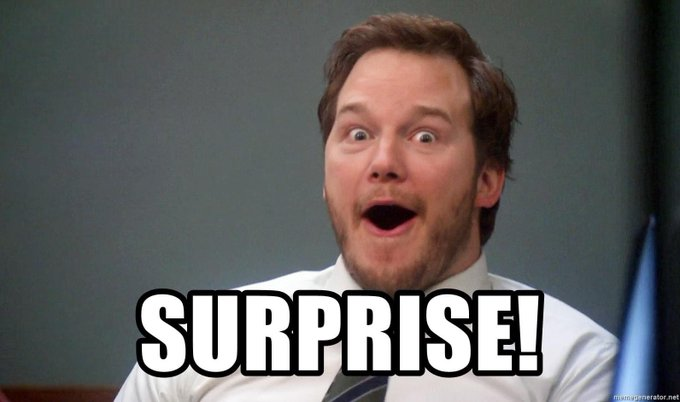

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [180]:
sample = pd.read_csv("./data/sample_submission.csv")

In [181]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [182]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [183]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID": X_pred.index, "Price_in_euros": predictions_submit_optimized})

In [184]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1921.713952
1,1281,591.573106
2,1168,496.168638
3,1231,1179.366974
4,1020,733.340147


In [185]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [186]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [187]:
chequeador(submission)

You're ready to submit!


In [ ]:
X_pred.columns

Index(['ram_gb', 'weight_kg', 'Frecuencia_GHz', 'type_Notebook', 'type_Gaming',
       'total_pixels', 'total_memory_gb'],
      dtype='object')

In [ ]:
X_train.columns

Index(['ram_gb', 'weight_kg', 'inches', 'type_Notebook', 'i7',
       'total_memory_gb', 'total_pixels', 'type_Workstation'],
      dtype='object')